In [34]:
import talk.config as con

con.config_configManager()
con.config_matplotlib()

The Conditional Value at Risk
-------------------------------
https://en.wikipedia.org/wiki/Expected_shortfall

#### Thomas Schmelzer

The $\alpha=0.99$ tail of a loss distribution 
-----------------------------------------------
<img src="talk/tail.jpg" style="margin-left:auto; margin-right:auto; display:block">

* In this talk we assume losses are postive. Larger losses, more pain... We want negative losses!

* The value at risk $\mathtt{VaR}_{\alpha}$ at level $\alpha$ is (the smallest) loss such that $\alpha \%$ of losses are smaller than $\mathtt{VaR}_{\alpha}$.

* This does not say anything about the magnitude of the losses larger than the $\mathtt{VaR}_{\alpha}$. We can only make statements about their number: $n(1 - \alpha)$

* To describe the tail of the return distribution better one could use the Conditional Value at Risk $\mathtt{CVaR}_{\alpha}$, defined as the mean of the losses larger (or equal) than the $\mathtt{VaR}_{\alpha}$.


* We compute the mean of the largest $n(1-\alpha)$ entries of a vector (or a optimal linear combination of vectors) without ever sorting the entries of any vector. 

* The resulting convex program is linear.

* This mean is called Conditional Value at Risk $\mathtt{CVaR}_{\alpha}$ and is an upper bound for the Value at Risk $\mathtt{VaR}_{\alpha}$.


Given a vector $\mathbf{r}$ we introduce a free variable $\gamma$ and define the function $f$ as:
\begin{eqnarray}
f(\gamma) &=& \gamma + \frac{1}{n\,(1-\alpha)}\sum (r_i - \gamma)^{+}
\end{eqnarray}
This is a continuous and convex function (in $\gamma$). The first derivative is:
$$
f^{'}(\gamma) = 1 - \frac{\#\left\{r_i \geq \gamma\right\}}{n\,(1-\alpha)}
$$

If $\gamma$ such that $\#\{r_i \geq \gamma\}=n\,(1-\alpha)$:
- $\gamma$ is a minimizer of $f$. 
- $f(\gamma) =\mathtt{CVaR}_\alpha(\mathbf{r})$.

In particular:

* $f(\mathtt{VaR}_\alpha(\mathbf{r})) = \mathtt{CVaR}_\alpha(\mathbf{r})$. 

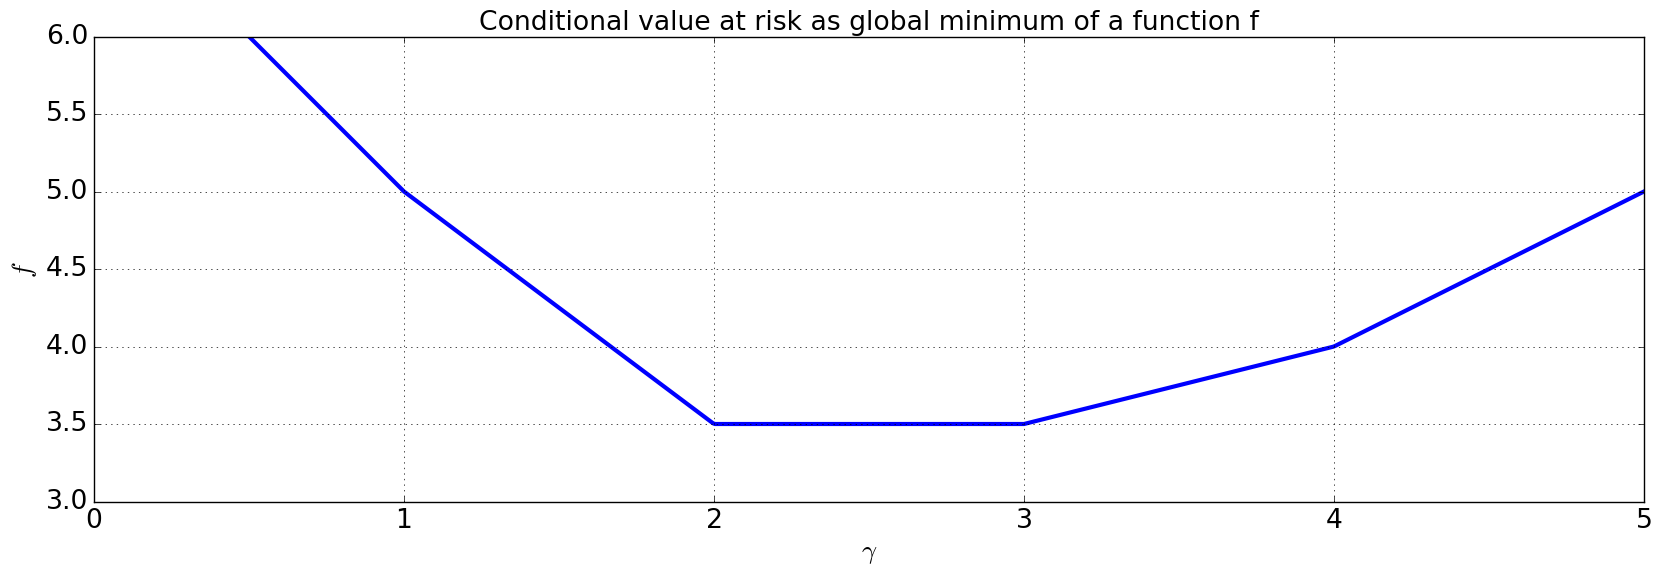

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def f(gamma, returns, alpha=0.99):
    excess = returns - gamma
    return gamma + 1.0 / (len(returns) * (1 - alpha)) * excess[excess > 0].sum()

# note that cvar = (3+4)/2  and var = ? ... depends on your definition. 2?, 3?, 2.5?
r = np.array([-1.0, 2.0, 3.0, 2.0, 4.0, 2.0, 0.0, 1.0, -2.0, -2.0])
x = np.linspace(start=-1.0, stop=5.0, num=1000)
v = np.array([f(gamma=g, returns=r, alpha=0.80) for g in x])

plt.plot(x, v), plt.grid(True), plt.xlabel('$\gamma$'), plt.ylabel('$f$')
plt.title('Conditional value at risk as global minimum of a function f')
plt.axis([0, 5, 3, 6])
plt.show()

Before (using conic reformulation of the $x^+$ function):

* \begin{align}\mathtt{CVaR}(\mathbf{r})=\min_{\gamma \in \mathbb{R}, \mathbf{t} \in \mathbb{R}^n} \,&\, \gamma + \frac{1}{n\,(1-\alpha)}\sum t_i\\
\text{s.t. }&t_i \geq r_i - \gamma \\
            &\mathbf{t}\geq 0
\end{align}

Now

* http://www.cvxpy.org/en/latest/tutorial/functions/, in particular the $x^{+} = \max\{0,x\}$

In [36]:
from cvx.util import minimize, cvx
import numpy as np

R = [-1.0, 2.0, 3.0, 2.0, 4.0, 2.0, 0.0, 1.0, -2.0, -2.0]

n = len(R)
# We are interested in CVaR for alpha=0.80, e.g. what's the mean of the 20% of the biggest losses
alpha = 0.80

# introduce the variable for the var
gamma = cvx.Variable(1) 
cvar = minimize(objective=gamma + 1.0/(n*(1-alpha)) * cvx.sum_entries(cvx.pos(R - gamma)))

print("A minimizer of f (<= VaR):  {0}".format(gamma.value))
print("Minimum of f (== CVaR):     {0}".format(cvar))

A minimizer of f (<= VaR):  2.5123507545372954
Minimum of f (== CVaR):     3.4999999998450733


Summary
-------

* We could compute the $\mathtt{CVaR}$ for a vector of length $n$ by solving a linear program.

* We do not need to sort the elements nor do we need to know the Value at Risk $\mathtt{VaR}$.

In practice the vector $\mathbf{r}$ is not given. Rather we have $m$ assets and try to find a linear combination of their corresponding return vectors such that the resulting portfolio has minimal Conditional Value at Risk.


Minimizer of f (<= VaR):  0.16087615020733823
Minimum of f (== CVaR):   0.18985952587088634


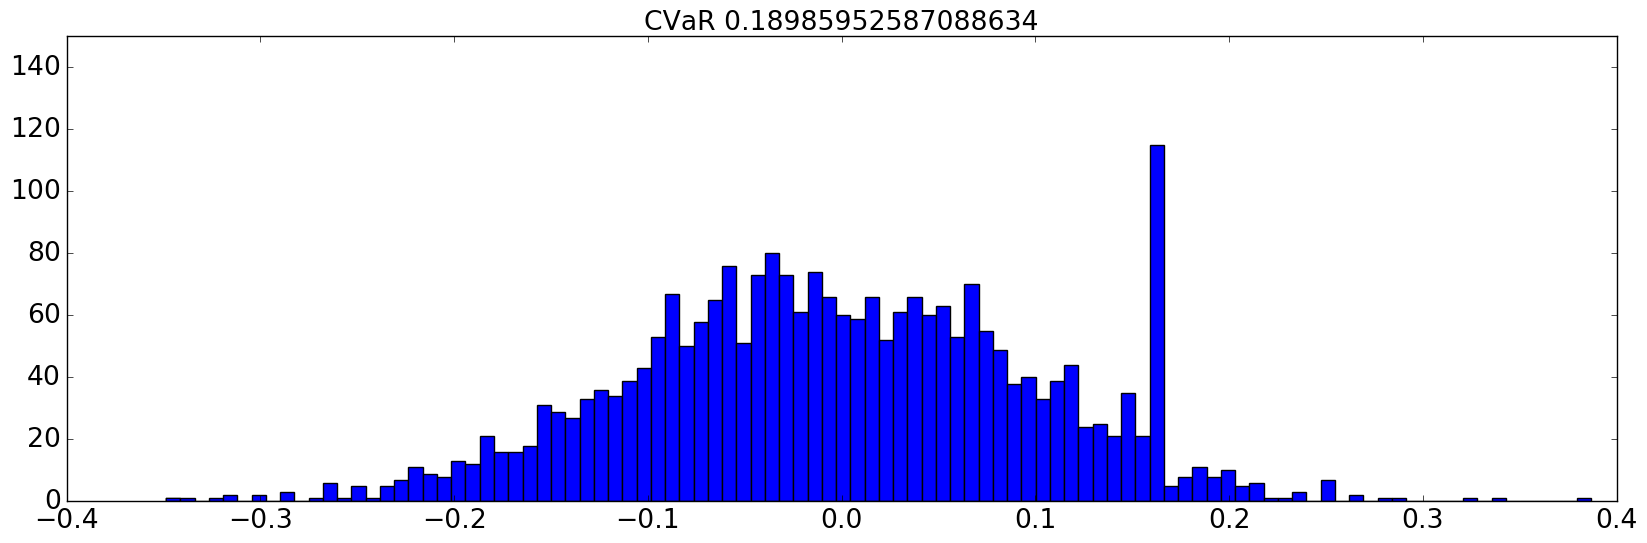

In [37]:
from cvx.util import cvx2np, minimize
import numpy as np
import matplotlib.pyplot as plt

R = np.random.randn(2500,100)

n,m = R.shape
# We are interested in CVaR for alpha=0.95, e.g. what's the mean of the 5% of the biggest losses
alpha = 0.95

gamma, w = (cvx.Variable(1), cvx.Variable(m))
constraints = [0 <= w, cvx.sum_entries(w) == 1]
obj = gamma + 1.0/(n*(1-alpha)) * cvx.sum_entries(cvx.pos(R*w - gamma))
cvar=minimize(objective=obj, constraints = constraints)
var = gamma.value

weights = np.array([w[i].value for i in range(0,m)])
print("Minimizer of f (<= VaR):  {0}".format(var))
print("Minimum of f (== CVaR):   {0}".format(cvar))

plt.hist(R @ weights, bins=100)
plt.axis([-0.4, 0.4, 0, 150])
plt.title("CVaR {0}".format(cvar))
plt.show()